# TODO
* Evaluer erreurs
* Voir les associations mots->classe
* Voir les ech. qui activent certaines classes

In [31]:
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.utils import to_categorical
from keras.regularizers import l2

from sklearn.metrics import classification_report

import classif

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
data, num_classes, gen = classif.load_data()

q_labels = ['Démocratie: Comment reprendre le pouvoir?',
'Économie: Comment développer le Québec selon nos priorités?',
'Régions: Comment dynamiser toutes nos communautés?',
'Indépendance: Comment se remettre en marche?',
'Éducation: Comment permettre à tout le monde de réaliser son plein potentiel?',
'Premiers Peuples: Comment construire la solidarité entre nous?',
'Diversité: Comment vivre ensemble sans racisme ni discrimination?',
'Culture: Comment favoriser une création artistique vivante et en assurer l’accès à tous?',
'Santé: Comment prendre soin de tout le monde?',
'Climat: Comment enclencher la transition?']

short_labels = ['Démocratie',
'Économie',
'Régions',
'Indépendance',
'Éducation',
'Premiers Peuples',
'Diversité',
'Culture',
'Santé',
'Climat']

N train, val, test: 3172 317 1799
Bin count train:  [777 157 411  39 821  83  26  97 192 569]
Bin count val:    [88 18 40  5 74  9  0  8 12 63]
Bin count test:   [483  83 232  29 461  35  14  44  94 324]


In [156]:
def build_model(num_classes, l2_reg):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64,), gamma_regularizer=l2(l2_reg)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg)))
    
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    return model


def train(model: Sequential, data, gen=None, verbose=1, epochs=10):
    print('Training...')
    if gen:
        history = model.fit_generator(gen(), 100, epochs=epochs, verbose=verbose,
                                      validation_data=(data['X_val'], data['y_val']))
    else:
        history = model.fit(data['X_train'], data['y_train'],
                            validation_data=(data['X_val'], data['y_val']),
                            verbose=verbose)
    
    return history
    

def test(model: Sequential, data):
    print('Testing...')
    results = model.evaluate(data['X_test'], data['y_test'])
    print('\nLoss: {}  Acc: {}'.format(*results))

In [60]:
# Perform grid search
# best l2_reg = 0.01
reg_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
results = {}

for reg in reg_list:
    print('Trying reg=' + str(reg))
    model = build_model(num_classes, reg)
    history = train(model, data, gen, verbose=0, epochs=40)
    val_acc = np.max(history.history['val_acc'])
    print('Val acc: ' + str(val_acc))
    results[reg] = val_acc

Trying reg=1e-06
Training...
Using gen
Val acc: 0.848580443709
Trying reg=1e-05
Training...
Using gen
Val acc: 0.82965299929
Trying reg=0.0001
Training...
Using gen
Val acc: 0.813880126935
Trying reg=0.001
Training...
Using gen
Val acc: 0.804416402845
Trying reg=0.01
Training...
Using gen
Val acc: 0.574132493618
Trying reg=0.1
Training...
Using gen
Val acc: 0.359621450258


In [166]:
# Train best model
model = build_model(num_classes, 1e-6)
history = train(model, data, gen, epochs=80)

Training...
Epoch 1/80
100/100 [==============================] - 7s - loss: 2.1491 - acc: 0.3578 - val_loss: 1.9947 - val_acc: 0.2934
Epoch 2/80
100/100 [==============================] - 1s - loss: 1.5424 - acc: 0.5047 - val_loss: 1.7171 - val_acc: 0.4353
Epoch 3/80
100/100 [==============================] - 1s - loss: 1.4034 - acc: 0.5494 - val_loss: 1.5333 - val_acc: 0.5110
Epoch 4/80
100/100 [==============================] - 1s - loss: 1.3065 - acc: 0.5853 - val_loss: 1.7720 - val_acc: 0.4732
Epoch 5/80
100/100 [==============================] - 1s - loss: 1.2106 - acc: 0.6106 - val_loss: 1.3626 - val_acc: 0.5174
Epoch 6/80
100/100 [==============================] - 1s - loss: 1.1039 - acc: 0.6462 - val_loss: 1.3937 - val_acc: 0.5773
Epoch 7/80
100/100 [==============================] - 1s - loss: 1.0303 - acc: 0.6659 - val_loss: 1.2699 - val_acc: 0.5899
Epoch 8/80
100/100 [==============================] - 1s - loss: 1.0287 - acc: 0.6597 - val_loss: 1.3014 - val_acc: 0.5710
Epoc

100/100 [==============================] - 1s - loss: 0.3711 - acc: 0.8878 - val_loss: 0.4342 - val_acc: 0.8644
Epoch 68/80
100/100 [==============================] - 0s - loss: 0.3859 - acc: 0.8703 - val_loss: 0.4174 - val_acc: 0.8612
Epoch 69/80
100/100 [==============================] - 0s - loss: 0.3435 - acc: 0.8875 - val_loss: 0.3592 - val_acc: 0.8896
Epoch 70/80
100/100 [==============================] - 1s - loss: 0.3565 - acc: 0.8841 - val_loss: 0.4097 - val_acc: 0.8770
Epoch 71/80
100/100 [==============================] - 1s - loss: 0.3770 - acc: 0.8787 - val_loss: 0.4555 - val_acc: 0.8580
Epoch 72/80
100/100 [==============================] - 1s - loss: 0.3832 - acc: 0.8744 - val_loss: 0.4653 - val_acc: 0.8360
Epoch 73/80
100/100 [==============================] - 1s - loss: 0.3631 - acc: 0.8828 - val_loss: 0.3950 - val_acc: 0.8360
Epoch 74/80
100/100 [==============================] - 1s - loss: 0.3454 - acc: 0.8847 - val_loss: 0.3325 - val_acc: 0.8896
Epoch 75/80
100/100 

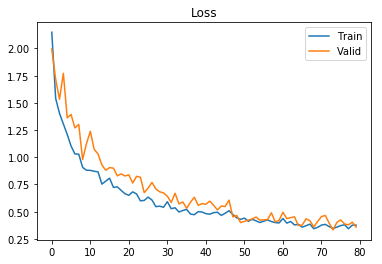

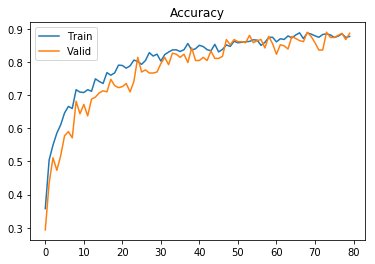

In [167]:
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.show()
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Valid')
plt.legend()
plt.show()

In [168]:
y_pred = model.predict(data['X_test'])
y_pred = to_categorical(np.argmax(y_pred, axis=1), num_classes)
test_acc = np.mean(y_pred == data['y_test'])
print('Test accuracy: ' + str(test_acc))
print(classification_report(data['y_test'], y_pred))

Test accuracy: 0.977098387993
             precision    recall  f1-score   support

          0       0.96      0.86      0.91       483
          1       0.88      0.95      0.91        83
          2       0.85      0.92      0.88       232
          3       0.90      0.93      0.92        29
          4       0.93      0.84      0.88       461
          5       0.85      0.94      0.89        35
          6       0.28      1.00      0.44        14
          7       0.76      1.00      0.86        44
          8       0.74      0.95      0.83        94
          9       0.94      0.90      0.92       324

avg / total       0.90      0.89      0.89      1799



In [92]:
import word2vec
import matplotlib.pyplot as plt
embedder = word2vec.Embedder()

Embedding answers...


In [138]:
def plot_pred(y_pred):
    ind = np.arange(num_classes)  # the x locations for the groups
    width = 0.35                  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, y_pred.ravel())

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Probabilité')
    ax.set_title('Sujet')
    ax.set_xticks(ind)
    ax.set_xticklabels(short_labels, rotation=70)

    plt.show()

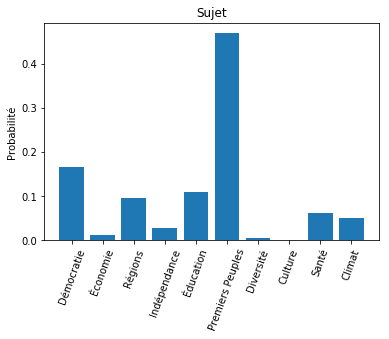

In [185]:
test_ans = embedder.embed_phrase('urgence')
somme = np.sum(np.abs(test_ans))
if somme < 1e-3:
    print('Mots inconnus. Somme: ' + str(somme))
y_pred = model.predict(test_ans[None, :])
plot_pred(y_pred)